In [12]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import math
import json
import numpy as np
import jax
import jax.numpy as jnp
import flax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import timecast as tc
import sklearn
import sklearn.linear_model
import sklearn.decomposition

from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from timecast.learners import ARXHistory
from timecast.optim import GradientDescent
from timecast import tscan

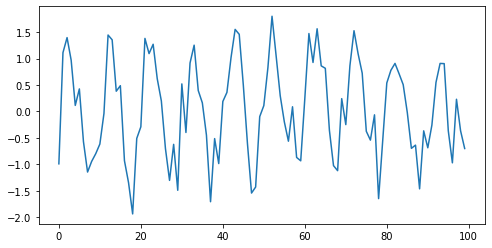

In [18]:
# data generator sinusoid + white noise
plt.rc('figure', figsize=(8,4))

def datagen(length, period, noise_level, seed):
    t = np.linspace(0, length-1, length)
    x = np.sin(2*np.pi/period * t)
    noise = jax.random.normal(jax.random.PRNGKey(seed), (length,)) * noise_level
    return x + noise

x = datagen(100,10,0.5,0)
plt.plot(x)

(80, 20) (80,)


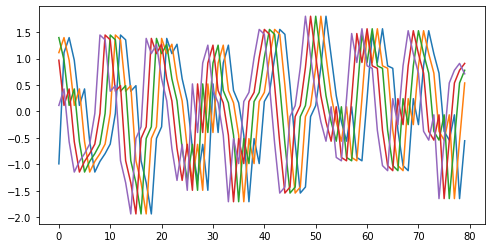

In [153]:
# generate sliding windows
plt.rc('figure', figsize=(8,4))

def AR_feat(x, H):
  X, Y = [], []
  for i in range(H, len(x)):
    X.append(x[i-H:i])
    Y.append(x[i])
  return np.array(X), np.array(Y)

X, Y = AR_feat(x, 20)
print(X.shape, Y.shape)
for i in range(5):
  plt.plot(X[:,i])

In [196]:
train_length = 100
test_length = 100
period = 10
noise_level = 0.5

x_train = datagen(train_length, period, noise_level, 0)
x_test = datagen(test_length, period, noise_level, 1)

In [155]:
def viz(truth, pred, title, **kwargs):
  plt.title(title)
  plt.plot(truth, color='gray')
  plt.plot(np.arange(len(truth)-len(pred), len(truth)), pred, **kwargs)

def trunc_mse(truth, pred):
  # compute truncated MSE, with shorter array of predictions
  return np.mean( (truth[len(truth)-len(pred):]-pred)**2 )

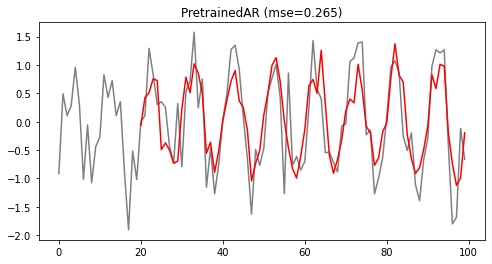

In [156]:
# Pre-trained AR
plt.rc('figure', figsize=(8,4))

def TestPretrainedAR(x_train, x_test, H):
  X_train, Y_train = AR_feat(x_train, H)
  X_test, Y_test = AR_feat(x_test, H)
  
  ls = sklearn.linear_model.Ridge(1e-20)
  ls.fit(X_train, Y_train)
  Y_pred = ls.predict(X_test)

  err = trunc_mse(Y_test, Y_pred)
  viz(x_test, Y_pred, title='PretrainedAR (mse=%.3f)' % err, color='red')

  return err

_ = TestPretrainedAR(x_train, x_test, 20)

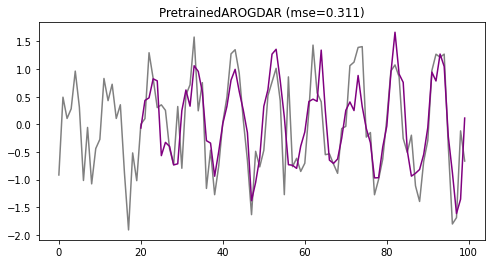

In [157]:
# Pre-trained AR, OGD AR
plt.rc('figure', figsize=(8,4))

def TestPretrainedAROGDAR(x_train, x_test, H):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
  
    ls = sklearn.linear_model.Ridge(1e-20)
    ls.fit(X_train, Y_train)
    
    model, state = ARXHistory.new(shapes=[(1, H, 1)])
    model.params["Targets"]["Linear"]["kernel"] = ls.coef_[:, None]
    model.params["Targets"]["Linear"]["bias"] = jnp.array(np.array([ls.intercept_]))
    optim_def = GradientDescent(learning_rate=10**-2)
    optimizer = optim_def.create(model)
    
    Y_pred, optimizer, state = tscan(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1), Y_test, optimizer, state=state)
    Y_pred = Y_pred.squeeze()

    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='PretrainedAROGDAR (mse=%.3f)' % err, color='purple')

    return err

_ = TestPretrainedAROGDAR(x_train, x_test, 20)

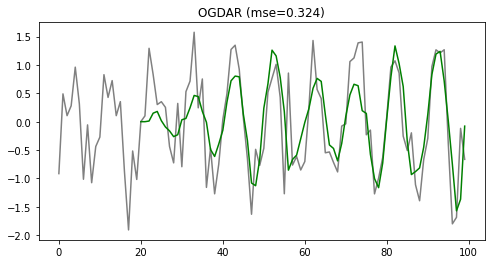

In [158]:
# OGD AR
plt.rc('figure', figsize=(8,4))

def TestOGDAR(x_train, x_test, H):
    X_test, Y_test = AR_feat(x_test, H)
    model, state = ARXHistory.new(shapes=[(1, H, 1)])
    optim_def = GradientDescent(learning_rate=10**-2)
    optimizer = optim_def.create(model)
    
    Y_pred, optimizer, state = tscan(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1), Y_test, optimizer, state=state)
    Y_pred = Y_pred.squeeze()
    
    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='OGDAR (mse=%.3f)' % err, color='green')
    return err
    
_ = TestOGDAR(x_train, x_test, 20)

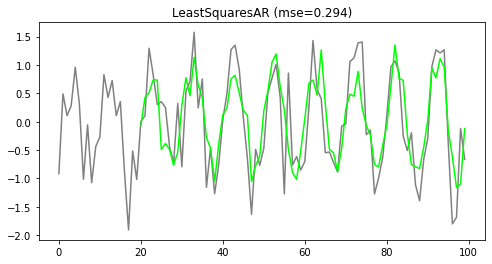

In [188]:
# Least Squares AR
plt.rc('figure', figsize=(8,4))

def TestLeastSquaresAR(x_train, x_test, H):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)
    
    ls = sklearn.linear_model.Ridge(1e-20)
    ls.fit(X_train, Y_train)
    
    Y_pred = []
    for x, y in zip(X_test, Y_test):
        X_train, Y_train = list(X_train), list(Y_train)
        
        Y_pred.append(ls.predict(x.reshape(1, -1)))
        
        X_train.append(x)
        Y_train.append(y)
        ls = sklearn.linear_model.Ridge(1e-20)
        
        X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)
        ls.fit(X_train, Y_train)

    err = trunc_mse(Y_test, np.array(Y_pred).squeeze())
    viz(x_test, Y_pred, title='LeastSquaresAR (mse=%.3f)' % err, color='lime')

    return err
    
err = TestLeastSquaresAR(x_train, x_test, 20)

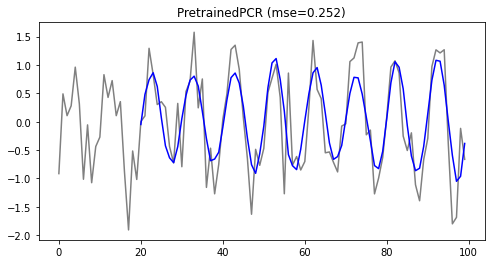

In [187]:
# Pre-trained PCR
plt.rc('figure', figsize=(8,4))

def TestPretrainedPCR(x_train, x_test, H, k):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)

    pca = sklearn.decomposition.PCA(k)
    ls = sklearn.linear_model.Ridge(1e-20)

    ls.fit(pca.fit_transform(X_train), Y_train)
    Y_pred = ls.predict(pca.transform(X_test))

    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='PretrainedPCR (mse=%.3f)' % err, color='blue')
    return err

_ = TestPretrainedPCR(x_train, x_test, 20, 2)

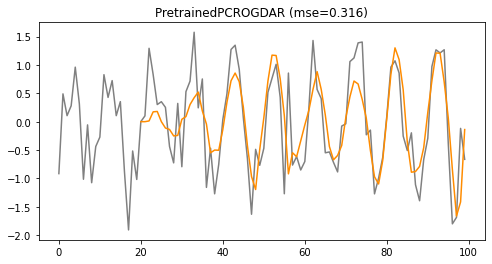

In [197]:
# Pre-trained PCR, OGD AR
plt.rc('figure', figsize=(8,4))

def TestPretrainedPCROGDAR(x_train, x_test, H, k):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)

    pca = sklearn.decomposition.PCA(k)
    pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    model, state = ARXHistory.new(shapes=[(1, k, 1)])
    optim_def = GradientDescent(learning_rate=10**-2)
    optimizer = optim_def.create(model)
    
    Y_pred, optimizer, state = tscan(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1), Y_test, optimizer, state=state)
    Y_pred = Y_pred.squeeze()

    err = trunc_mse(Y_test, Y_pred)
    viz(x_test, Y_pred, title='PretrainedPCROGDAR (mse=%.3f)' % err, color='darkorange')
    return err

_ = TestPretrainedPCROGDAR(x_train, x_test, 20, 2)

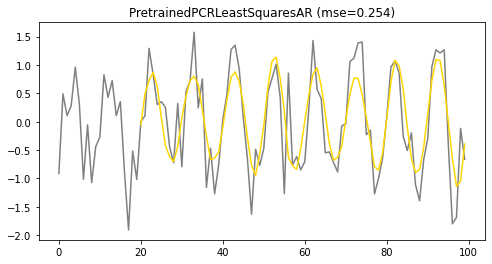

In [198]:
# Pre-trained PCR, Least Squares AR
plt.rc('figure', figsize=(8,4))

def TestPretrainedPCRLeastSquaresAR(x_train, x_test, H, k):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, H)

    pca = sklearn.decomposition.PCA(k)
    pca.fit_transform(X_train)
    
    ls = sklearn.linear_model.Ridge(1e-20)
    ls.fit(pca.fit_transform(X_train), Y_train)

    Y_pred = []
    for x, y in zip(X_test, Y_test):
        X_train, Y_train = list(X_train), list(Y_train)
        
        Y_pred.append(ls.predict(pca.transform(x.reshape(1, -1))))
        
        X_train.append(x)
        Y_train.append(y)
        pca = sklearn.decomposition.PCA(k)
        
        X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)
        pca.fit_transform(X_train)

        ls = sklearn.linear_model.Ridge(1e-20)
        ls.fit(pca.fit_transform(X_train), Y_train)

    err = trunc_mse(Y_test, np.array(Y_pred).squeeze())
    viz(x_test, Y_pred, title='PretrainedPCRLeastSquaresAR (mse=%.3f)' % err, color='gold')
    return err

_ = TestPretrainedPCRLeastSquaresAR(x_train, x_test, 20, 2)

In [151]:
# OnlinePCR, Frank-Wolfe

"""
𝛂 (jnp.ndarray): a vector of length W
x (jnp.ndarray): true values from 0 to W - 1
𝛘 (jnp.ndarray): W histories with d * H dimensions
B (jnp.ndarray): Projection matrix from d * H dimensions to d * H dimensions
𝜆 (float): regularization factor

𝜑(𝛂, B) = 𝓁(-𝜆 * W * 𝛂, x) / W + 𝜆 / 2 * 𝛂.T @ 𝛘 @ B @ 𝛘.T @ 𝛂

d𝜑(𝛂, B)/d𝛂 = (-𝜆 * W * 𝛂 - x) / W + 𝜆 * 𝛘 @ B @ 𝛘.T @ 𝛂
            = 0
            
𝛂 = (I - 𝛘 @ B @ 𝛘.T)^-1 @ (-x / (W * 𝜆))
"""

def min_𝛂(x, 𝛘, B, W, 𝜆):
    XBX = 𝛘 @ B @ 𝛘.T
    inv = jnp.linalg.inv(jnp.eye(XBX.shape[0]) - XBX)
    return inv @ (-x / (W * 𝜆))

def grad_phi_B(𝛂, 𝛘, 𝜆):
    return - 𝜆 / 2 * 𝛂.T @ 𝛘 @ 𝛘.T @ 𝛂

def grad_F_B(B, G, 𝛽, 𝜂, B0):
    return 𝜂 * G + 𝛽 * (B - B0)

def TestOnlinePCRFW(x_train, x_test, H, W):
    X_train, Y_train = AR_feat(x_train, H)
    X_test, Y_test = AR_feat(x_test, W)
    
    d = 1
    C = 1
    G = 0
    B = jnp.zeros((d * H, d * H))
    B0 = B
    𝜆 = 1.0

    T = X_test.shape[0]
    
    print(x_test.shape, X_test.shape)
    print(X_test[-1][-1], x_test[-2], x_test[-1])
    
    for t in range(1, T + 1):
        M = jax.scipy.linalg.cholesky(B)
        
        print(M)
        break
        
        print(M @ x_test[t - 1 : t + W - 1], B)
        
        # Question: Better choice for initializing 𝛂?
        𝛂 = min_𝛂(x_test[t - 1 : t + W - 1], X_test[t - 1 : t + W - 1], B, W, 𝜆)
        
        G += grad_phi_B(𝛂, X_test[t - 1 : t + W - 1], 𝜆)
        
        FB = grad_F_B(B, G, 4 / (𝜆 * (t ** 1/4)), 1 / jnp.sqrt(t), B0)
        
        eigvals, eigvecs = jax.scipy.linalg.eigh(M)
        v = eigvecs[np.argmax(eigvals)]
        
        𝛾 = 1 / t
        B = 𝛾 * C * v @ v.T + (1 - 𝛾) * B
    
_ = TestOnlinePCRFW(x_train, x_test, 20, 20)

(100,) (80, 20)
-1.3683232 -1.3683232 -1.5086255
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0.  0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0.  0.  0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0.  0.  0.  0.  0.  0. nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. nan nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan nan nan nan nan nan nan nan
  nan nan]
 [ 0.  0.  0.  0

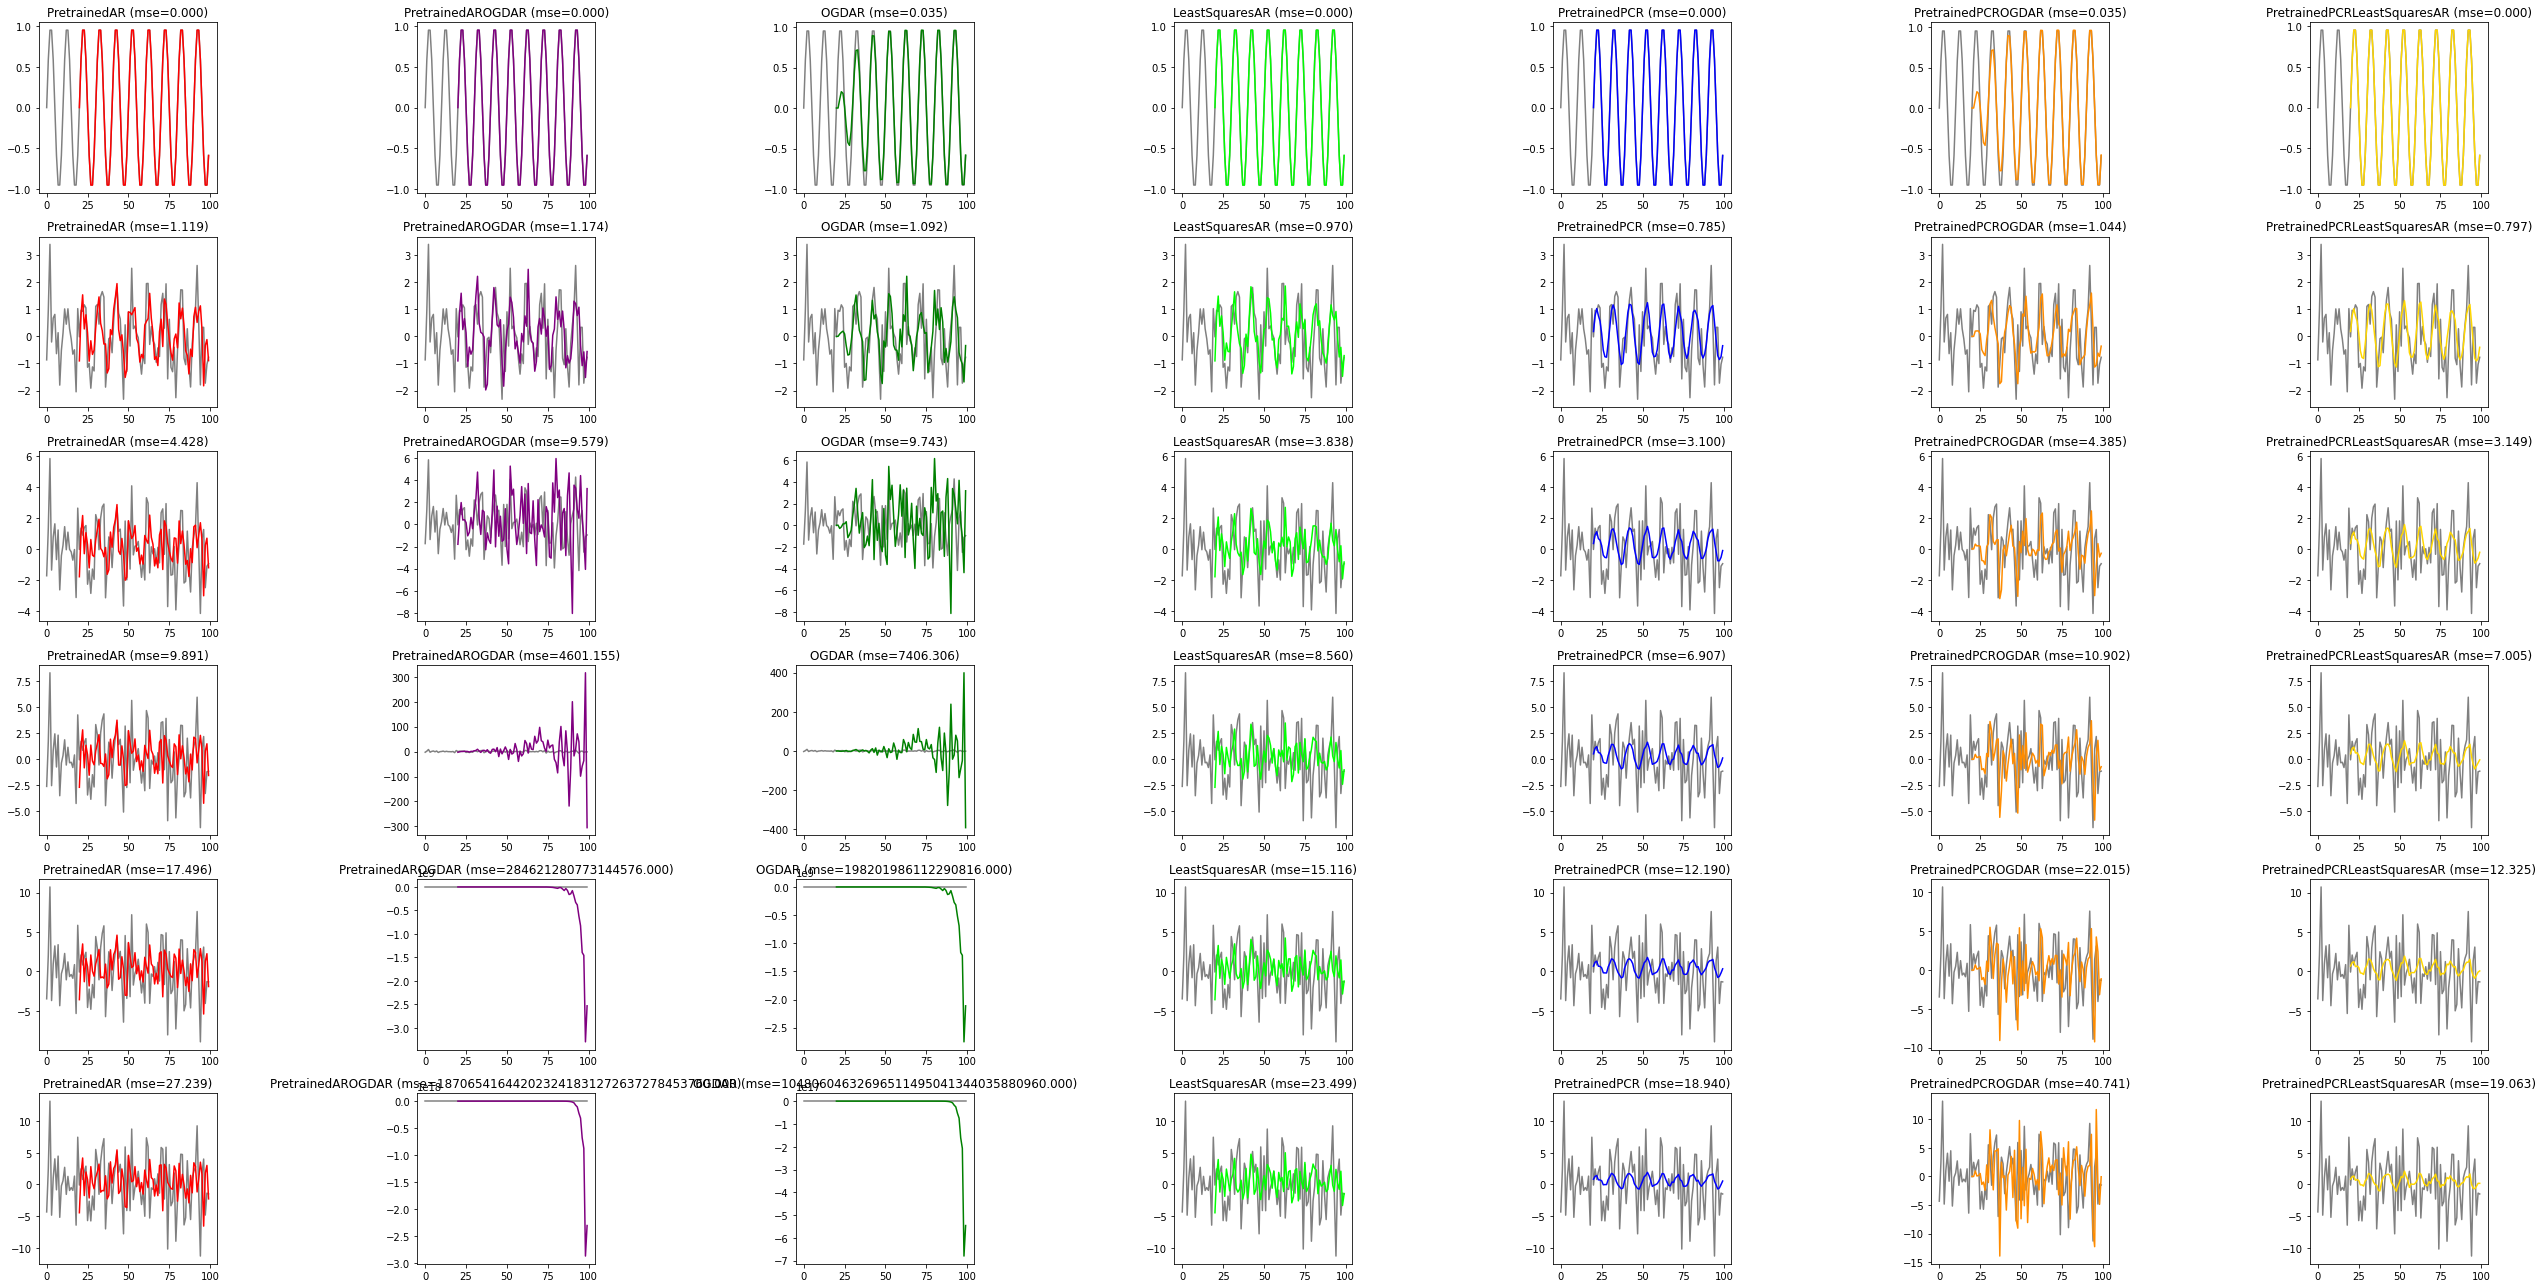

In [203]:
# wiggle the noise level

train_length = 100
test_length = 100
period = 10
noise_levels = np.linspace(0, 4, 6)

H = 20
k = 2

loss_table = []

num_figs = 7

plt.rc('figure', figsize=(num_figs * 5, 3*len(noise_levels)))

for i,noise_level in enumerate(noise_levels):
    x_train = datagen(train_length, period, noise_level, 0)
    x_test = datagen(test_length, period, noise_level, 124)
    x_pure = datagen(test_length, period, 0, 2)

    plt.subplot(len(noise_levels), num_figs, num_figs*i+1)
    loss_pretrained_ar = TestPretrainedAR(x_train, x_test, H)
    
    plt.subplot(len(noise_levels), num_figs, num_figs*i+2)
    loss_pretrained_ar_ogd_ar = TestPretrainedAROGDAR(x_train, x_test, H)
    
    plt.subplot(len(noise_levels), num_figs, num_figs*i+3)
    loss_ogd_ar = TestOGDAR(x_train, x_test, H)
    
    plt.subplot(len(noise_levels), num_figs, num_figs*i+4)
    loss_least_squares_ar = TestLeastSquaresAR(x_train, x_test, H)

    plt.subplot(len(noise_levels), num_figs, num_figs*i+5)
    loss_pretrained_pcr = TestPretrainedPCR(x_train, x_test, H, k)

    plt.subplot(len(noise_levels), num_figs, num_figs*i+6)
    loss_pretrained_pcr_ogd_ar = TestPretrainedPCROGDAR(x_train, x_test, H, k)
    
    plt.subplot(len(noise_levels), num_figs, num_figs*i+7)
    loss_pretrained_pcr_least_squares_ar = TestPretrainedPCRLeastSquaresAR(x_train, x_test, H, k)
    
    loss_pure = trunc_mse(x_test, x_pure[H:])

    loss_table.append( [loss_pretrained_ar,
                        loss_pretrained_ar_ogd_ar,
                        loss_ogd_ar,
                        loss_least_squares_ar,
                        loss_pretrained_pcr,
                        loss_pretrained_pcr_ogd_ar,
                        loss_pretrained_pcr_least_squares_ar,
                        loss_pure] )

loss_table = np.array(loss_table)
plt.tight_layout()

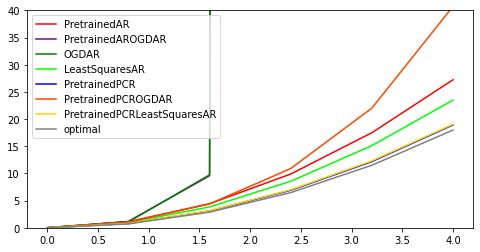

In [204]:
# plot losses from above

plt.rc('figure', figsize=(8,4))
colors = ["red", "purple", "green", "lime", "blue", "orangered", "gold", "gray"]
labels = ['PretrainedAR', 'PretrainedAROGDAR', 'OGDAR', 'LeastSquaresAR', 'PretrainedPCR','PretrainedPCROGDAR', 'PretrainedPCRLeastSquaresAR', 'optimal']
for i in range(num_figs + 1):
    plt.plot(noise_levels, loss_table[:,i], color=colors[i], label=labels[i])

plt.ylim((0, 40))
plt.legend()